In [1]:
from tokenisation import midi_parser, events_parser
from preprocessing import *
from utils import *
from markov_model import VOMM
from transformer_training import MusicTransformerTrainer
from transformer_generation import load_model, generate
from evaluation import *
import glob
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data Loading and Preprocessing:

Creating the training data: (Requires the MAESTRO V3.0.0 MIDI dataset to be downloaded into the same directory as this file!)

In [ ]:
# Get MAESTRO file paths
filenames = glob.glob(str("maestro-v3.0.0/*/*.mid*"))

In [ ]:
# Tokenise the MIDI files
data = []
for filename in filenames:
    index_list = midi_parser(filename)
    data.append(index_list)

# Sample sequences and endings of roughly length 1024
data = crop_sequences(data, 1024) + crop_endings(data, 1024)
# Perform data augmentation in the form of pitch shifting and time stretching
data = augment(data)
# Randomly shuffle the data
data = data[torch.randperm(data.shape[0])]

torch.save(data, "preprocessed_data.pt")

Loading the training data:

In [3]:
# Load the data
data = torch.load("data/preprocessed_data.pt").long()

# 80/20 train/validation split
train_len = round(data.shape[0] * 0.8)
train_data = data[:train_len]
val_data = data[train_len:]
print(f"There are {data.shape[0]} sequences in the data: {len(train_data)} training sequences and {len(val_data)} validation sequences.")

There are 63800 sequences in the data: 51040 training sequences and 12760 validation sequences.


# Training:

Code to train the Markov model:

In [3]:
# Code to train on full training set - note that this takes a large amount of memory and time, so we did not use this approach

# # Get Markov model
# markov_model = VOMM(max_order=4)

# # Insert data into the model
# for seq in train_data:
#     # Insert sequences without padding
#     markov_model.insert_sequence(seq[torch.ne(seq, 0)].tolist())

# # Save model
# with open("data/markov_model.pkl", "wb") as markov_save:
#     pickle.dump(markov_model, markov_save, pickle.HIGHEST_PROTOCOL)

In [8]:
# Code to train on a random subset of 102 training sequences - we did this 500 times in our evaluation section

# Get Markov model
markov_model = VOMM(max_order=4)

# Insert data into the model
for seq in train_data[torch.randperm(train_data.size(0))[:102]]:
    # Insert sequences without padding
    markov_model.insert_sequence(seq[torch.ne(seq, 0)].tolist())

# Save model
with open("data/markov_model.pkl", "wb") as markov_save:
    pickle.dump(markov_model, markov_save, pickle.HIGHEST_PROTOCOL)

Training the Music Transformer:

In [ ]:
# Define hyperparameters
hparams = {
    "hidden_dim": 128,
    "num_layers": 3,
    "num_heads": 8,
    "ff_hidden_dim": 512,
    "max_rel_dist": 512,
    "max_abs_position": 20000,
    "vocab_size": vocab_size,
    "bias": True,
    "dropout": 0.1,
    "layernorm_eps": 1e-6
}
batch_size = 16
epochs = 30

# Initialise trainer
trainer = MusicTransformerTrainer(hparams, train_data, val_data, batch_size, "data/music_transformer.pt", True) # Load from checkpoint at "music_transformer.pt"
# Train the model
trainer.fit(epochs)

The Music Transformer's training progress:

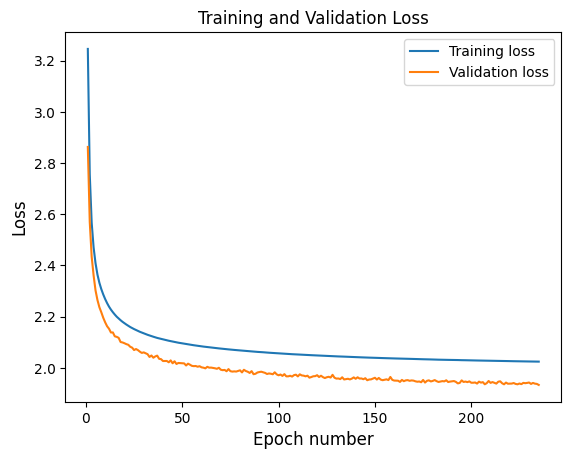

In [4]:
# Load in training and validation losses
training_data = torch.load("data/music_transformer.pt", map_location=device)
train_losses, val_losses = training_data["train_losses"], training_data["validation_losses"]
epochs = len(train_losses)

# Plot loss curves
plt.plot(range(1, epochs+1), train_losses, label="Training loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch number", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()

# Generation:

In [5]:
# Load models
with open("data/markov_model.pkl", "rb") as markov_save:
    markov_model = pickle.load(markov_save)
music_transformer = load_model("data/music_transformer.pt")
    
# Initialise the system

system = {"markov": markov_model,
          "transformer": music_transformer,
          "save_path": "generated.midi"}

Generating with the Markov model:

In [ ]:
# Unconditional generation - 3 different modes (can stop generation if taking too long by interrupting the cell!)
generated_sequence = system["markov"].generate_sequence(selector="event_count_weight")
# generated_sequence = system["markov"].generate_sequence(selector="event_count_weight", mode="c_min", c=2)
# generated_sequence = system["markov"].generate_sequence(selector="context_length_weight")

# Convert to MIDI file
generated_sequence = events_parser(generated_sequence)

# Save MIDI file
generated_sequence.save(system["save_path"])

# Load the file back in and convert to audio
ipd.Audio(get_audio(system["save_path"]), rate=Fs)

In [ ]:
######
# Requires the MAESTRO V3.0.0 MIDI dataset to be downloaded into the same directory as this file!
######
# Conditional generation - 3 different modes (can stop generation if taking too long by interrupting the cell!)
generated_sequence = system["markov"].generate_sequence(start=midi_parser(filenames[0])[:50], selector="event_count_weight")
# generated_sequence = system["markov"].generate_sequence(start=midi_parser(filenames[0])[:50], selector="event_count_weight", mode="c_min", c=2)
# generated_sequence = system["markov"].generate_sequence(start=midi_parser(filenames[0])[:50], selector="context_length_weight")

# Convert to MIDI file
generated_sequence = events_parser(generated_sequence)

# Save MIDI file
generated_sequence.save(system["save_path"])

# Load the file back in and convert to audio
ipd.Audio(get_audio(system["save_path"]), rate=Fs)

In [ ]:
######
# Requires the MAESTRO V3.0.0 MIDI dataset to be downloaded into the same directory as this file!
######
# Here is the audio the above output is conditioned on
ipd.Audio(get_audio(filenames[0], seconds=3), rate=Fs)

Generating with Music Transformer:

In [ ]:
# Unconditional generation (can stop generation if taking too long by interrupting the cell!)
generated_sequence = generate(system["transformer"])

# Convert to MIDI file
generated_sequence = events_parser(generated_sequence)

# Save MIDI file
generated_sequence.save(system["save_path"])

# Load the file back in and convert to audio
ipd.Audio(get_audio(system["save_path"]), rate=Fs)

In [15]:
######
# Requires the MAESTRO V3.0.0 MIDI dataset to be downloaded into the same directory as this file!
######
# Conditional generation (can stop generation if taking too long by interrupting the cell!)
generated_sequence = generate(system["transformer"], midi_parser(filenames[0])[:50])

# Convert to MIDI file
generated_sequence = events_parser(generated_sequence)

# Save MIDI file
generated_sequence.save(system["save_path"])

# Load the file back in and convert to audio
ipd.Audio(get_audio(system["save_path"]), rate=Fs)

In [21]:
######
# Requires the MAESTRO V3.0.0 MIDI dataset to be downloaded into the same directory as this file!
######
# Here is the audio the above output is conditioned on
ipd.Audio(get_audio(filenames[0], seconds=3), rate=Fs)

Generating with both:

In [22]:
# Conditioning the Music Transformer output on a Markov output

# Generate a sequence using Markov model
generated_sequence = system["markov"].generate_sequence(selector="event_count_weight")
# Remove the end token
if generated_sequence[-1] == end_token_index:
    generated_sequence = generated_sequence[:-1]

# Generate sequence conditioned on the Markov output
generated_sequence = generate(system["transformer"], generated_sequence)

# Convert to MIDI file
generated_sequence = events_parser(generated_sequence)

# Save MIDI file
generated_sequence.save(system["save_path"])

# Load the file back in and convert to audio
ipd.Audio(get_audio(system["save_path"]), rate=Fs)

In [ ]:
# Conditioning the Markov output on a Music Transformer output

# Generate sequence using the Music Transformer
generated_sequence = generate(system["transformer"])
# Remove the end token
if generated_sequence[-1] == end_token_index:
    generated_sequence = generated_sequence[:-1]

# Generate a sequence conditioned on the Music Transformer output
generated_sequence = system["markov"].generate_sequence(start=generated_sequence, selector="context_length_weight")

# Convert to MIDI file
generated_sequence = events_parser(generated_sequence)

# Save MIDI file
generated_sequence.save(system["save_path"])

# Load the file back in and convert to audio
ipd.Audio(get_audio(system["save_path"]), rate=Fs)

# Evaluation:

Randomly sample 500 sequences from the validation data:

In [ ]:
val_sequences = val_data[torch.randperm(val_data.size(0))[:500]]
real_samples = [seq[torch.ne(seq, 0)].tolist() for seq in val_sequences] # Remove padding from sequences

# Save samples as a csv
with open("data/real_samples.csv", "w+", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(real_samples)

Generate 500 samples from the Markov model:

In [5]:
# We trained 500 separate VOMMs, each on a random subset of 102 training sequences, and generated a sample from each
markov_samples = []
for i in range(500):
    # Get Markov model
    markov_model = VOMM(max_order=4)

    # Insert data into the model
    for seq in train_data[torch.randperm(train_data.size(0))[:102]]:
        # Insert sequences without padding
        markov_model.insert_sequence(seq[torch.ne(seq, 0)].tolist())

    # Generate a sequence
    generated_sequence = markov_model.generate_sequence(selector="event_count_weight")
    markov_samples.append(generated_sequence)

# Save samples as a csv
with open("data/markov_samples.csv", "w+", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(markov_samples)

Generate 500 samples from the Music Transformer:

In [ ]:
# Load Music Transformer
music_transformer = load_model("data/music_transformer.pt")

transformer_samples = []
for i in range(500):
    # Generate sequence
    generated_sequence = generate(music_transformer)
    transformer_samples.append(generated_sequence)

# Save samples as a csv
with open("data/transformer_samples.csv", "w+", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(transformer_samples)

Calculating features for each set of samples:

In [2]:
# For the real samples
real_samples = []
with open("data/real_samples.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        sample = []
        for token in row:
            sample.append(int(token))
        real_samples.append(sample)
real_features = features(real_samples)
real_features_mean_std = mean_std_features(real_samples)

# For the Markov samples
markov_samples = []
with open("data/markov_samples.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        sample = []
        for token in row:
            sample.append(int(token))
        markov_samples.append(sample)
markov_features = features(markov_samples)
markov_features_mean_std = mean_std_features(markov_samples)

# For the Music Transformer samples
transformer_samples = []
with open("data/transformer_samples.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        sample = []
        for token in row:
            sample.append(int(token))
        transformer_samples.append(sample)
transformer_features = features(transformer_samples)
transformer_features_mean_std = mean_std_features(transformer_samples)

In [3]:
features_df = pd.DataFrame([real_features_mean_std, markov_features_mean_std, transformer_features_mean_std], index=["real", "markov", "transformer"])
features_df.drop(columns=["mean_pitch_class_histogram", "std_dev_pitch_class_histogram", "mean_pitch_class_transition_matrix", "std_dev_pitch_class_transition_matrix"])

,mean_pitch_count,std_dev_pitch_count,mean_pitch_range,std_dev_pitch_range,mean_avg_pitch_interval,std_dev_avg_pitch_interval,mean_note_count,std_dev_note_count,mean_avg_inter_onset_interval,std_dev_avg_inter_onset_interval
real,41.154,10.670627,57.484000,11.629004,-0.023382,0.097156,236.998,26.512902,107.019910,68.585057
markov,46.766,19.134243,60.558233,14.532253,-0.035582,1.159905,283.358,281.697366,104.305410,54.341446
transformer,42.592,10.901080,59.891566,11.598725,-0.008427,0.245089,232.372,53.112085,91.795064,44.487373


Performing t-tests to investigate significant differences:

In [4]:
t_test_results = {}

for feature in ["pitch_counts", "pitch_ranges", "avg_pitch_intervals", "note_counts", "avg_inter_onset_intervals"]:
    real_values = real_features[feature]
    markov_values = markov_features[feature]
    transformer_values = transformer_features[feature]

    # T-test between real sample values and VOMM sample values
    markov_p, markov_rej = t_test(real_values, markov_values)

    # T-test between real sample values and Music Transformer sample values
    transformer_p, transformer_rej = t_test(real_values, transformer_values)

    t_test_results[feature+"_p"] = [markov_p, transformer_p]
    t_test_results[feature+"_rej"] = [markov_rej, transformer_rej]

t_test_results_df = pd.DataFrame(t_test_results, index=["markov", "transformer"])
t_test_results_df

,pitch_counts_p,pitch_counts_rej,pitch_ranges_p,pitch_ranges_rej,avg_pitch_intervals_p,avg_pitch_intervals_rej,note_counts_p,note_counts_rej,avg_inter_onset_intervals_p,avg_inter_onset_intervals_rej
markov,1.498596e-08,True,0.000242,True,0.815348,False,0.000278,True,0.489005,False
transformer,3.547210e-02,True,0.001108,True,0.206333,False,0.082138,False,0.000036,True


Investigating (normalised) mean pitch class histograms:

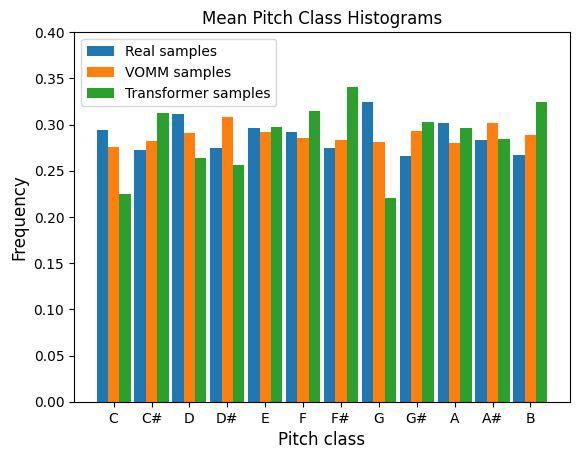

In [16]:
pitch_classes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

bar_width = 0.3
r1 = np.arange(12)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

real_pch = features_df.at["real", "mean_pitch_class_histogram"]
markov_pch = features_df.at["markov", "mean_pitch_class_histogram"]
transformer_pch = features_df.at["transformer", "mean_pitch_class_histogram"]

plt.bar(r1, real_pch / np.linalg.norm(real_pch), width=bar_width, label="Real samples")
plt.bar(r2, markov_pch / np.linalg.norm(markov_pch), width=bar_width, label="VOMM samples")
plt.bar(r3, transformer_pch / np.linalg.norm(transformer_pch), width=bar_width, label="Transformer samples")
plt.xticks([r + bar_width for r in range(12)], pitch_classes)
plt.xlabel("Pitch class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim(0, 0.4)
plt.title("Mean Pitch Class Histograms")
plt.legend()
plt.show()

And (row-normalised) mean pitch class transition matrices:

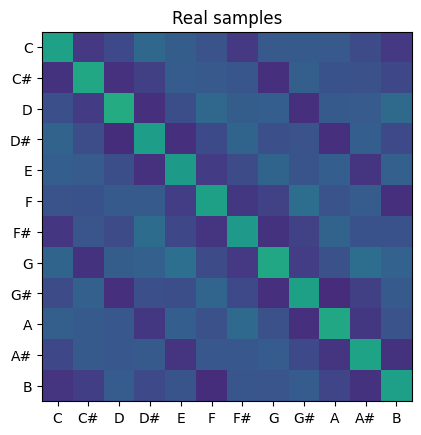

In [20]:
real_pctm = features_df.at["real", "mean_pitch_class_transition_matrix"]
plt.imshow(real_pctm / np.linalg.norm(real_pctm, axis=1), vmin=0, vmax=1)
plt.xticks(range(12), pitch_classes)
plt.yticks(range(12), pitch_classes)
plt.title("Real samples")
plt.show()

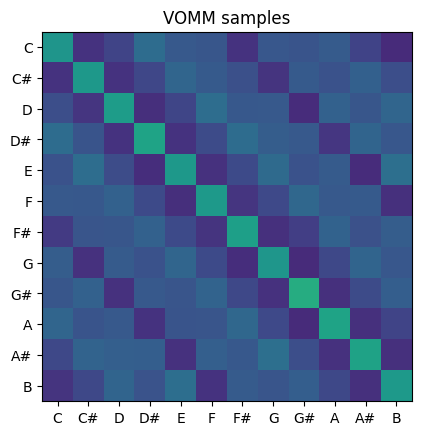

In [21]:
markov_pctm = features_df.at["markov", "mean_pitch_class_transition_matrix"]
plt.imshow(markov_pctm / np.linalg.norm(markov_pctm, axis=1), vmin=0, vmax=1)
plt.xticks(range(12), pitch_classes)
plt.yticks(range(12), pitch_classes)
plt.title("VOMM samples")
plt.show()

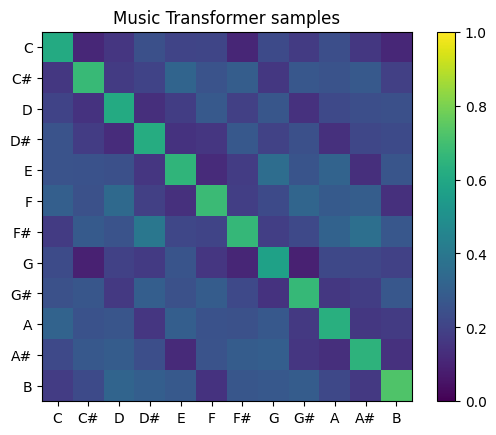

In [22]:
transformer_pctm = features_df.at["transformer", "mean_pitch_class_transition_matrix"]
plt.imshow(transformer_pctm / np.linalg.norm(transformer_pctm, axis=1), vmin=0, vmax=1)
plt.xticks(range(12), pitch_classes)
plt.yticks(range(12), pitch_classes)
plt.colorbar()
plt.title("Music Transformer samples")
plt.show()